<a href="https://colab.research.google.com/github/TieuLang/CS114.K21.KHTN/blob/master/DoAnMayHoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Họ và tên: Nguyễn Quyết Thắng**

**MSSV:      18520152**
1. Mô tả bài toán:
Đồ án về nhận diện hoa
2.Input:
Một ảnh có chứa bông hoa của một trong 12 loài hoa (hoa Dừa Cạn, hoa Bông Trang, hoa Hồng, hoa Giấy, hoa Chi Cúc, hoa Lan Hồ Điệp, hoa Sứ, hoa Huỳnh Anh) 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd "/content/gdrive/My Drive/Flower_dataset"
!cp "/content/gdrive/My Drive/Flower_dataset/flowers.zip" "/content/"
%cd "/content/"

/content/gdrive/My Drive/Flower_dataset
/content


In [ ]:
import os
import glob
import datetime
import cv2

flowers_dataset_name = 'flowers.zip'
train_dir      = os.path.join(os.getcwd(),"dataset")
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
%cd "dataset"
!unzip "/content/flowers.zip" 
# Đổi tên file 'jpg' trong thư mục đã giải nén thành train
if os.path.exists(train_dir + "/jpg"):
    print("Access dataset successfully")
    print("Rename ...")
    os.rename(train_dir + "/jpg", train_dir + "/train")

In [5]:
# Lấy tất cả hình ảnh từ dataset
image_paths = sorted(glob.glob(train_dir + "/train/*.jpg"))
print("Number of image in dataset: {}".format(len(image_paths)))
print(image_paths)

Number of image in dataset: 1200
['/content/dataset/train/image_0001.jpg', '/content/dataset/train/image_0002.jpg', '/content/dataset/train/image_0003.jpg', '/content/dataset/train/image_0004.jpg', '/content/dataset/train/image_0005.jpg', '/content/dataset/train/image_0006.jpg', '/content/dataset/train/image_0007.jpg', '/content/dataset/train/image_0008.jpg', '/content/dataset/train/image_0009.jpg', '/content/dataset/train/image_0010.jpg', '/content/dataset/train/image_0011.jpg', '/content/dataset/train/image_0012.jpg', '/content/dataset/train/image_0013.jpg', '/content/dataset/train/image_0014.jpg', '/content/dataset/train/image_0015.jpg', '/content/dataset/train/image_0016.jpg', '/content/dataset/train/image_0017.jpg', '/content/dataset/train/image_0018.jpg', '/content/dataset/train/image_0019.jpg', '/content/dataset/train/image_0020.jpg', '/content/dataset/train/image_0021.jpg', '/content/dataset/train/image_0022.jpg', '/content/dataset/train/image_0023.jpg', '/content/dataset/train

In [7]:
# Tạo giới hạn loài hoa
class_limit = 12
class_names = ["hoa dua can", "hoa bong trang", "hoa hong", "hoa giay", "hoa chi cuc", "hoa lan ho diep","hoa su", "hoa huynh anh", "hoa cuc", "hoa mao ga", "hoa chieu tim", "hoa dong tien"]
label = 0
i = 0
j = 100
for x in range(1, class_limit+1):
    # tạo folder cho mỗi loài hoa
    os.makedirs(train_dir + "/train/" + class_names[label])
    # Lấy link hiện tại
    cur_path = train_dir + "/train/" + class_names[label] + "/"
    # Chuyển ảnh qua link mới
    for index, image_path in enumerate(image_paths[i:j], start=1):
      original_path   = image_path
      image_file_name = str(index) + ".jpg"
      os.rename(original_path, cur_path + image_file_name)
    i += 100
    j += 100
    label += 1

In [6]:
!pip install mahotas
!pip install h5py

     |████████████████████████████████| 5.7MB 2.6MB/s 


In [8]:
#Chiết xuất đặc trưng
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import h5py

# Điều chỉnh tham số
images_per_class = 100
fixed_size       = tuple((500, 500))
output_path = os.path.join(train_dir, "output")
if not os.path.exists(output_path):
  os.mkdir(output_path)
train_path = os.path.join(train_dir, "train")
h5_data          = os.path.join(output_path, "data.h5")
h5_labels        = os.path.join(output_path, "labels.h5")
bins             = 8

In [9]:
# Rút trích đặc trưng bằng Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick
    
# Rút trích đặc trưng bằng Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    return hist.flatten()

# Rút trích đặc trưng bằng Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature


In [10]:
# Lấy nhãn tập train
train_labels = os.listdir(train_path)
# Sắp xếp nhãn tập train
train_labels.sort()
print(train_labels)

['hoa bong trang', 'hoa chi cuc', 'hoa chieu tim', 'hoa cuc', 'hoa dong tien', 'hoa dua can', 'hoa giay', 'hoa hong', 'hoa huynh anh', 'hoa lan ho diep', 'hoa mao ga', 'hoa su']


In [11]:
# khởi tạo mảng lưu feature vectors và labels
global_features = []
labels          = []
#Duyệt qua các tệp dữ liệu train
for training_name in train_labels:
    dir = os.path.join(train_path, training_name)
    # Lấy label của tệp
    current_label = training_name
    # Duyệt các ảnh của tệp
    for x in range(1,images_per_class+1):
        # Lấy tên file ảnh
        file = dir + "/" + str(x) + ".jpg"
        # Resize ảnh
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        # Cập nhật danh sách
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: hoa bong trang
[STATUS] processed folder: hoa chi cuc
[STATUS] processed folder: hoa chieu tim
[STATUS] processed folder: hoa cuc
[STATUS] processed folder: hoa dong tien
[STATUS] processed folder: hoa dua can
[STATUS] processed folder: hoa giay
[STATUS] processed folder: hoa hong
[STATUS] processed folder: hoa huynh anh
[STATUS] processed folder: hoa lan ho diep
[STATUS] processed folder: hoa mao ga
[STATUS] processed folder: hoa su
[STATUS] completed Global Feature Extraction...


In [13]:
# lấy kích thước của feature vector
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# lấy  kích thước của training label
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# gán nhãn cho mỗi labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# chia lại tỷ lệ cua feature vector
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# lưu feature vector
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] feature vector size (1200, 532)
[STATUS] training Labels (1200,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [ 0  0  0 ... 11 11 11]
[STATUS] target labels shape: (1200,)
[STATUS] end of training..


In [21]:
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

num_trees = 100
test_size = 0.20
seed      = 9
test_path  = os.path.join(train_dir, "test")
if not os.path.exists(test_path):
  os.mkdir(test_path)
scoring = "accuracy"

# tạo các model máy học
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))
models.append(('LinearSVC', LinearSVC(C=1, loss='squared_hinge', penalty='l2',multi_class='ovr')))

# khởi tạo mảng lưu kết quả và tên
results = []
names   = []

# thêm feature vector và các trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()


In [22]:
# chia dữ liệu thành tập train và tập test
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features), np.array(global_labels), test_size=test_size, random_state=seed)

print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

Train data  : (960, 532)
Test data   : (240, 532)
Train labels: (960,)
Test labels : (240,)


LR: 0.960417 (0.020199)
KNN: 0.912500 (0.030262)
RF: 0.968750 (0.010417)
SVM: 0.959375 (0.012715)
LinearSVC: 0.968750 (0.023292)


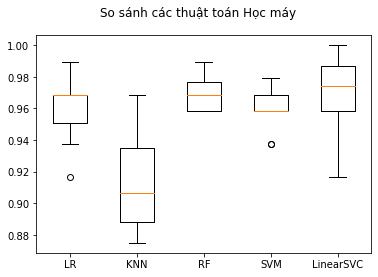

In [23]:
# cài đặt kĩ thuật cross-validation để tránh model bị overfitting
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
fig = pyplot.figure()
fig.suptitle('So sánh các thuật toán Học máy')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Dự đoán với tập dữ liệu chưa được train với model tốt nhất(Random Forests)

Dự đoán với tập test nhỏ

ảnh được upload lên thư mục: /content/dataset/test"

link drive: https://drive.google.com/drive/folders/1YWahZ9IGkjehYlbX3ozRWyZ8BA5TAAIl?usp=sharing

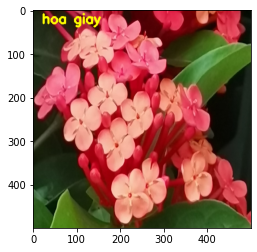

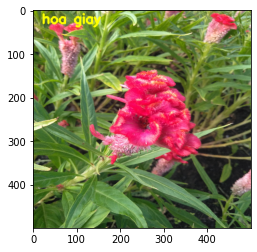

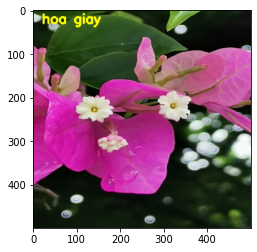

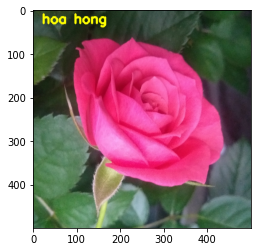

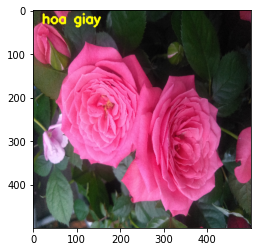

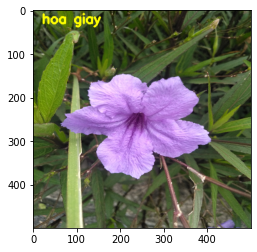

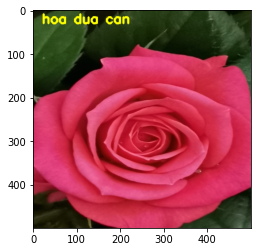

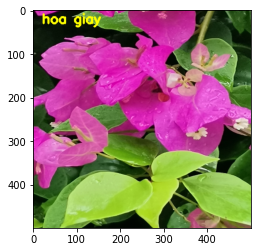

In [25]:
import matplotlib.pyplot as plt

# tạo model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
clf.fit(trainDataGlobal, trainLabelsGlobal)

# Với mỗi ảnh test
for file in glob.glob(test_path + "/*.jpg"):
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments]).reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_feature)
    # dự đoán label của ảnh test
    prediction = clf.predict(rescaled_feature.reshape(1, -1))[0]
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

test với file flowers_test.zip

link drive: 

In [33]:
%cd "/content/gdrive/My Drive/Flower_dataset"
!cp "/content/gdrive/My Drive/Flower_dataset/flowers_test.zip" "/content/"
%cd "/content/"
%cd "dataset/test/"
!unzip "/content/flowers_test.zip"

import matplotlib.pyplot as plt

clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

clf.fit(trainDataGlobal, trainLabelsGlobal)

prediction_labels = []
test_labels = []
for i in range(0, class_limit):
  for _ in range(0, 10):
    test_labels.append(i)
new_flowers_test_path = test_path + "/flowers_test"
for file in glob.glob(new_flowers_test_path + "/*.jpg"):
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments]).reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_feature)
    prediction = clf.predict(rescaled_feature.reshape(1, -1))[0]
    prediction_labels.append(prediction)

/content/gdrive/My Drive/Flower_dataset
/content
/content/dataset/test
Archive:  /content/flowers_test.zip
   creating: flowers_test/
  inflating: flowers_test/image_001.jpg  
  inflating: flowers_test/image_0011.jpg  
  inflating: flowers_test/image_0012.jpg  
  inflating: flowers_test/image_0013.jpg  
  inflating: flowers_test/image_0014.jpg  
  inflating: flowers_test/image_0015.jpg  
  inflating: flowers_test/image_0016.jpg  
  inflating: flowers_test/image_0017.jpg  
  inflating: flowers_test/image_0018.jpg  
  inflating: flowers_test/image_0019.jpg  
  inflating: flowers_test/image_002.jpg  
  inflating: flowers_test/image_0020.jpg  
  inflating: flowers_test/image_003.jpg  
  inflating: flowers_test/image_004.jpg  
  inflating: flowers_test/image_005.jpg  
  inflating: flowers_test/image_006.jpg  
  inflating: flowers_test/image_007.jpg  
  inflating: flowers_test/image_008.jpg  
  inflating: flowers_test/image_009.jpg  
  inflating: flowers_test/image_010.jpg  
  inflating: flo

Kết quả

In [34]:
prediction_report = classification_report(test_labels, prediction_labels)
print(prediction_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.18      0.20      0.19        10
           6       0.10      0.80      0.17        10
           7       0.07      0.20      0.11        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10

    accuracy                           0.10       120
   macro avg       0.03      0.10      0.04       120
weighted avg       0.03      0.10      0.04       120



#Đánh giá và kết luận

- Model Random Forest bị overfiting. Dự đoán sai với các ảnh trong test set.
- Hệ thống này không thể áp dụng được trong thực tế

#Hướng phát triển

- Tiếp tục cập nhật gia tăng số lượng và chất lượng của dataset
- Tìm hiểu các phương pháp rút trích đặc trưng khác như CNN.



